# RRAM Characterization Analysis Notebook

This notebook contains Python analyses of data collected on the 256x256 (64K) TCAM array developed at Stanford. The TCAM has 4 WLs that are addressed by a single WL addr, and 2 BLs that are addressed by a single SL addr.

## Notebook setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib.patches import Rectangle

%config InlineBackend.figure_formats = ["svg"]

## FORMing

### Load log file

The log file contains all the data from the dynamic FORM process. We need to parse it and look at some statistical properties of the FORMing process.

In this dataset, FORMing is done by dynamically incrementing VWL by 50mV starting from 1.3V until the cell resistance falls below 10kOhm. The VBL is fixed at 3.3V and the pulse width is 1ms.

In [2]:
# Load log file
names = ["chip", "time", "addr", "operation", "data0", "data1", "data2", "data3"]
data = pd.read_csv("../data/form2_log.csv", names=names)

# Get data from last FORM pulse and final resistance measurement only
read_data = data[data["operation"] == "READ"].groupby("addr").nth(-1)
form_data = data[data["operation"] == "SET"].groupby("addr").nth(-1)

# For SET operations: (data0, data1, data2, data3) = (VWL, VBL, VSL, PW)
# For READ operations: (data0, data1, data2, data3) = (res, g, meas_i, meas_v)
# res = resistance, g = conductance

data.head()

,chip,time,addr,operation,data0,data1,data2,data3
0,C6,1.619165e+09,0,SET,1.300000e+00,3.300000e+00,0.000000e+00,0.001000
1,C6,1.619165e+09,0,READ,9.533862e+03,1.048893e-04,1.981402e-05,0.011096
2,C6,1.619165e+09,1,SET,1.300000e+00,3.300000e+00,0.000000e+00,0.001000
3,C6,1.619165e+09,1,READ,2.021986e+06,4.945633e-07,9.888527e-08,0.000055
4,C6,1.619165e+09,1,SET,1.350000e+00,3.300000e+00,0.000000e+00,0.001000


### FORMing VWL Distribution

As shown by the distribution, most cells FORM with a single pulse as indicated by the large bar at 1.3V (first pulse). The rest of the cells appear to FORM in a manner that looks like the right half of a Gaussian distribution.

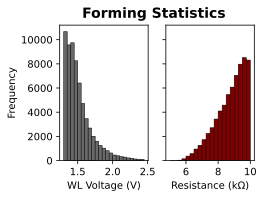

In [3]:
# VWL Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 2.5), sharey=True)
fig.suptitle("Forming Statistics", fontsize=14, fontweight="bold")
form_data["data0"].hist(bins=np.arange(1.3, 2.50001, 0.05001), ax=ax1, edgecolor="black", linewidth=0.5, color="dimgray")
(read_data["data0"]/1000).hist(bins=np.arange(5, 10.1, 0.25001), ax=ax2, edgecolor="black", linewidth=0.5, color="maroon")
ax1.set_xlabel("WL Voltage (V)")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax2.set_xlabel("Resistance (kΩ)")
ax2.grid(False)
ax2.set_xticks(range(6,12,2))
plt.savefig("figs/forming_statistics.pdf", bbox_inches="tight")
plt.show()

<a id="retention"></a>
## Retention and Read Noise
In this section, we evaluate how well the cells can maintain their conductance values after programming. We first program 1024 cells (using the first bitline). After each cell is programmed, we immediately measure the short-term relaxation by performing 1000 READs. After all cells are programmed, we measure the long-term relaxation by continuously reading all cells.

In [26]:
# Open read file
names = ["addr", "time", "r", "g"]
data = pd.read_csv("../data/relaxdata.tsv.gz", names=names, sep="\t")
data["time"] = data["time"] - data.groupby("addr")["time"].transform("first")
data["dg"] = data["g"] - data.groupby("addr")["g"].transform("first")
data["absdg"] = np.abs(data["dg"])
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
data.head()

,addr,time,r,g,dg,absdg,targbin
0,0,0.000000,394055.654398,0.000003,0.000000e+00,0.000000e+00,0.0
1,0,0.008992,375526.174252,0.000003,1.252176e-07,1.252176e-07,0.0
2,0,0.014989,349686.935004,0.000003,3.219882e-07,3.219882e-07,0.0
3,0,0.017986,360976.997817,0.000003,2.325470e-07,2.325470e-07,0.0
4,0,0.020987,356374.604909,0.000003,2.683235e-07,2.683235e-07,0.0


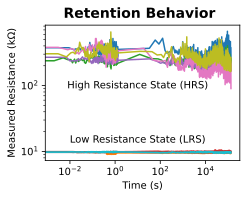

In [27]:
# Plot measured conductance vs. time
levels = [0, 25, 32 + 0, 32 + 25, 64 + 0, 64 + 25, 128 + 0, 128 + 25, 192 + 0, 192 + 25]
plt.figure(figsize=(3.5,2.5))
plt.suptitle("Retention Behavior", fontsize=14, fontweight="bold")
plt.xlabel("Time (s)")
plt.ylabel("Measured Resistance (kΩ)")
for addr in np.array(levels)*2:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["r"]/1e3)
plt.xscale("log")
plt.yscale("log")
#rect = Rectangle((3.8, 12), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
#plt.gca().add_patch(rect)
#plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.text(10, 100, "High Resistance State (HRS)", ha="center", va="center")
plt.text(10, 15, "Low Resistance State (LRS)", ha="center", va="center")
#plt.text(10, 40, "(Each color represents a different cell)", ha="center", va="center", fontsize=8)
plt.savefig("figs/retention.pdf", bbox_inches="tight")
plt.show()

## Programmed Distributions

Below, we showcase what the resistance distributions of LRS and HRS look like.

In [6]:
# Load bitstream
bs = np.loadtxt(open("../bitstream/vectors_bitstream.txt"), delimiter=",", skiprows=0, dtype=np.int32)

# Load target output as dataframe
CHIP = 6
ITER = 2
cols = ["addr", "READS", "SETS", "RESETS", "success", "R"]
dtypes = {
    "addr": np.int32,
    "READS": np.int32,
    "SETS": np.int32,
    "RESETS": np.int32,
    "success": np.int32,
    "R": np.float64
}
progdata = pd.read_csv(f"../data/target_chip{CHIP}.csv", names=cols, sep='\t', dtype=dtypes, index_col="addr")[65536*ITER:65536*(ITER+1)]
progdata["bin"] = bs

# Load read target output as dataframe
cols = ["addr", "V", "I", "R"]
dtypes = {
    "addr": np.int32,
    "V": np.float64,
    "I": np.float64,
    "R": np.float64
}
readdata = pd.read_csv(f"../data/read_target_chip{CHIP}.csv", names=cols, sep='\t', dtype=dtypes, index_col="addr")[65536*ITER:65536*(ITER+1)]
readdata["bin"] = bs

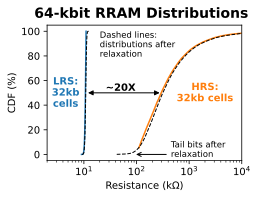

In [7]:
# CDF curves
plt.figure(figsize=(3.5,2.5))
plt.xlim(2, 1e4)
plt.xscale("log")
plt.suptitle("64-kbit RRAM Distributions", fontsize=14, fontweight="bold")
for i in range(2):
    rdata = progdata[progdata["bin"] == i]
    counts, bin_edges = np.histogram(rdata["R"]/1000, bins=65536, density=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1]*100)
for i in range(2):
    rdata = readdata[readdata["bin"] == i]
    counts, bin_edges = np.histogram(rdata["R"]/1000, bins=65536, density=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1]*100, "k--", linewidth=1)
plt.annotate("", xy=(11, 50), xytext=(300, 50), arrowprops=dict(arrowstyle="<|-|>", facecolor='k'))
plt.annotate("", xy=(90, 0), xytext=(400, 0), arrowprops=dict(arrowstyle="->", facecolor='k'), va="bottom")
plt.text(450, -2, "Tail bits after\nrelaxation", fontsize=8.5)
plt.text(20, 100, "Dashed lines:\ndistributions after\nrelaxation", fontsize=8.5, va="top")
plt.text(50, 50, "~20X", ha="center", va="bottom", fontweight="bold")
plt.text(4.5, 50, "LRS:\n32kb\ncells", color=plt.gca().lines[0].get_color(), ha="center", va="center", fontweight="bold")
plt.text(2000, 50, "HRS:\n32kb cells", color=plt.gca().lines[1].get_color(), ha="center", va="center", fontweight="bold")
plt.xlabel("Resistance (kΩ)")
plt.ylabel("CDF (%)")
plt.savefig("figs/prog_dists.pdf", bbox_inches="tight")
plt.show()

## Endurance

To measure endurance, we perform SET/RESET cycling using a hardware-timed pulse train without READing (fast mode). The pulse train waveform is verified with the oscilloscope. We also validate with a software-timed pulse train (slow mode), which generally exhibits good agreement with the hardware-timed pulse train. We test different SET conditions at 1us and 20ns. We are basically unable to get the cells to fail in a reasonable amount of testing time.

In [22]:
# Load endurance data
data = pd.read_csv("../data/endurance_log.csv", header=None)
data = data[data[3] == "READ"]
data["r"] = np.float64(data[4])
data.head()

,0,1,2,3,4,5,6,7,8,9,r
2,C4,1.619202e+09,778,READ,28039.719590468696,3.566369473751519e-05,0.000007,0.003916,NaN,NaN,28039.719590
4,C4,1.619202e+09,778,READ,8048.942333574365,0.00012423992601223187,0.000023,0.013010,NaN,NaN,8048.942334
7,C4,1.619202e+09,778,READ,102529.76247895055,9.753265547701829e-06,0.000002,0.001086,NaN,NaN,102529.762479
9,C4,1.619202e+09,778,READ,10149.338725646337,9.85285866430985e-05,0.000019,0.010458,NaN,NaN,10149.338726
12,C4,1.619202e+09,778,READ,121114.23117392651,8.256668025774333e-06,0.000002,0.000920,NaN,NaN,121114.231174


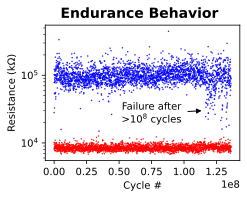

In [24]:
# Show cycling up to 1e8
plt.figure(figsize=(3.5,2.5))
plt.suptitle("Endurance Behavior", fontsize=14, fontweight="bold")
plt.xlabel("Cycle #")
plt.ylabel("Resistance (kΩ)")
plt.yscale("log")
t = plt.annotate("Failure after\n>10$^8$ cycles", xy=(1.15e8, 30e3), xytext=(0.75e8, 20e3), arrowprops=dict(arrowstyle="-|>", facecolor='k'), ha="center")
t.set_bbox(dict(facecolor="white", alpha=0.86, edgecolor="white"))
plt.plot(np.arange(len(data["r"][::2]))*5e4, data["r"][::2], "b.", ms=1)
plt.plot(np.arange(len(data["r"][1::2]))*5e4, data["r"][1::2], "r.", ms=1)
plt.savefig("figs/endurance.pdf", bbox_inches="tight")
plt.show()